Hey All,

This is my first real shot at creating a model for this competition after going through all the tutorials. I have used a couple of other notebooks as reference to create this one. I would suggest reading these notebooks as well. I have tried to keep the process simple and provided explanations wherever necessary. This notebook has it's own fallacies but helps one understand the general process flow for modeling. The issues with this notebook are listed below and will be addressed in the next notebook.
Please feel free to give me feedback on my approach.

[House Prices: 1st Approach to Data Science Process](https://www.kaggle.com/cheesu/house-prices-1st-approach-to-data-science-process) by Chee Su Goh - Very clear approach to feature engineering and modeling. A must read for new Kagglers.

[Sagar](https://www.kaggle.com/sagarmainkar/sagar) by Sagar Mainakar - Excellent exploration and analysis of data for feature engineering.

[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne - Very clear and simple explanation. Though I didn't implment model stacking in this notebook. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from scipy.stats import norm, skew
from scipy import stats

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

### Step by step outline of the entire model

Preparation steps for feature engineering
- Read train and test data
- Drop 'Id' and save for later
- Treat outliers in the training dataset
- Check Target skewness and logarithmize
- Merge train and test data to form all_data

Missing Values
- Exploring missing values in the dataset
- Impute missing values appropriately till no missing values are present

Feature Engineering
- Drop highly correlated columns
- Exploring categorical columns with low cardinality
- But first transforming skewed categorical features
- One Hot Encoding the remaining categorical features with low cardinality
- Split the dataset back to train and test
- Make sure that all the missing values have been imputed and categorical features have been transformed

Modeling
- Breaking the training data from the validation data
- Create a function to inverse transform SalePrive after prediction call
- Build series to collate mean absolute errors for each algorithm
- Implementing the selected models
- Identify the model with the lowest mean absolute error
- Cross Validate models
- Fitting The winning model as the final model
- Create submissions file

### Problems with the current model
- Data leakage issues due to merging of train and test data
- Imputation on the merged dataset
- Feature engineering not very creative
- Need to learn model stacking and hyperparameter tuning

### Read train and test data

In [2]:
df_train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
df_test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

### Drop 'Id' and save for later

In [3]:
train_id = df_train['Id']
test_id = df_test['Id']

In [4]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [5]:
print('Train dataset shape:', df_train.shape)
print('Test dataset shape:', df_test.shape)

Train dataset shape: (1460, 80)
Test dataset shape: (1459, 79)


### Treating outliers in the training dataset

In [6]:
# Creating num_cols to explore outliers in numerical columns 
num_cols = df_train.select_dtypes(exclude='object').drop('SalePrice', axis=1)

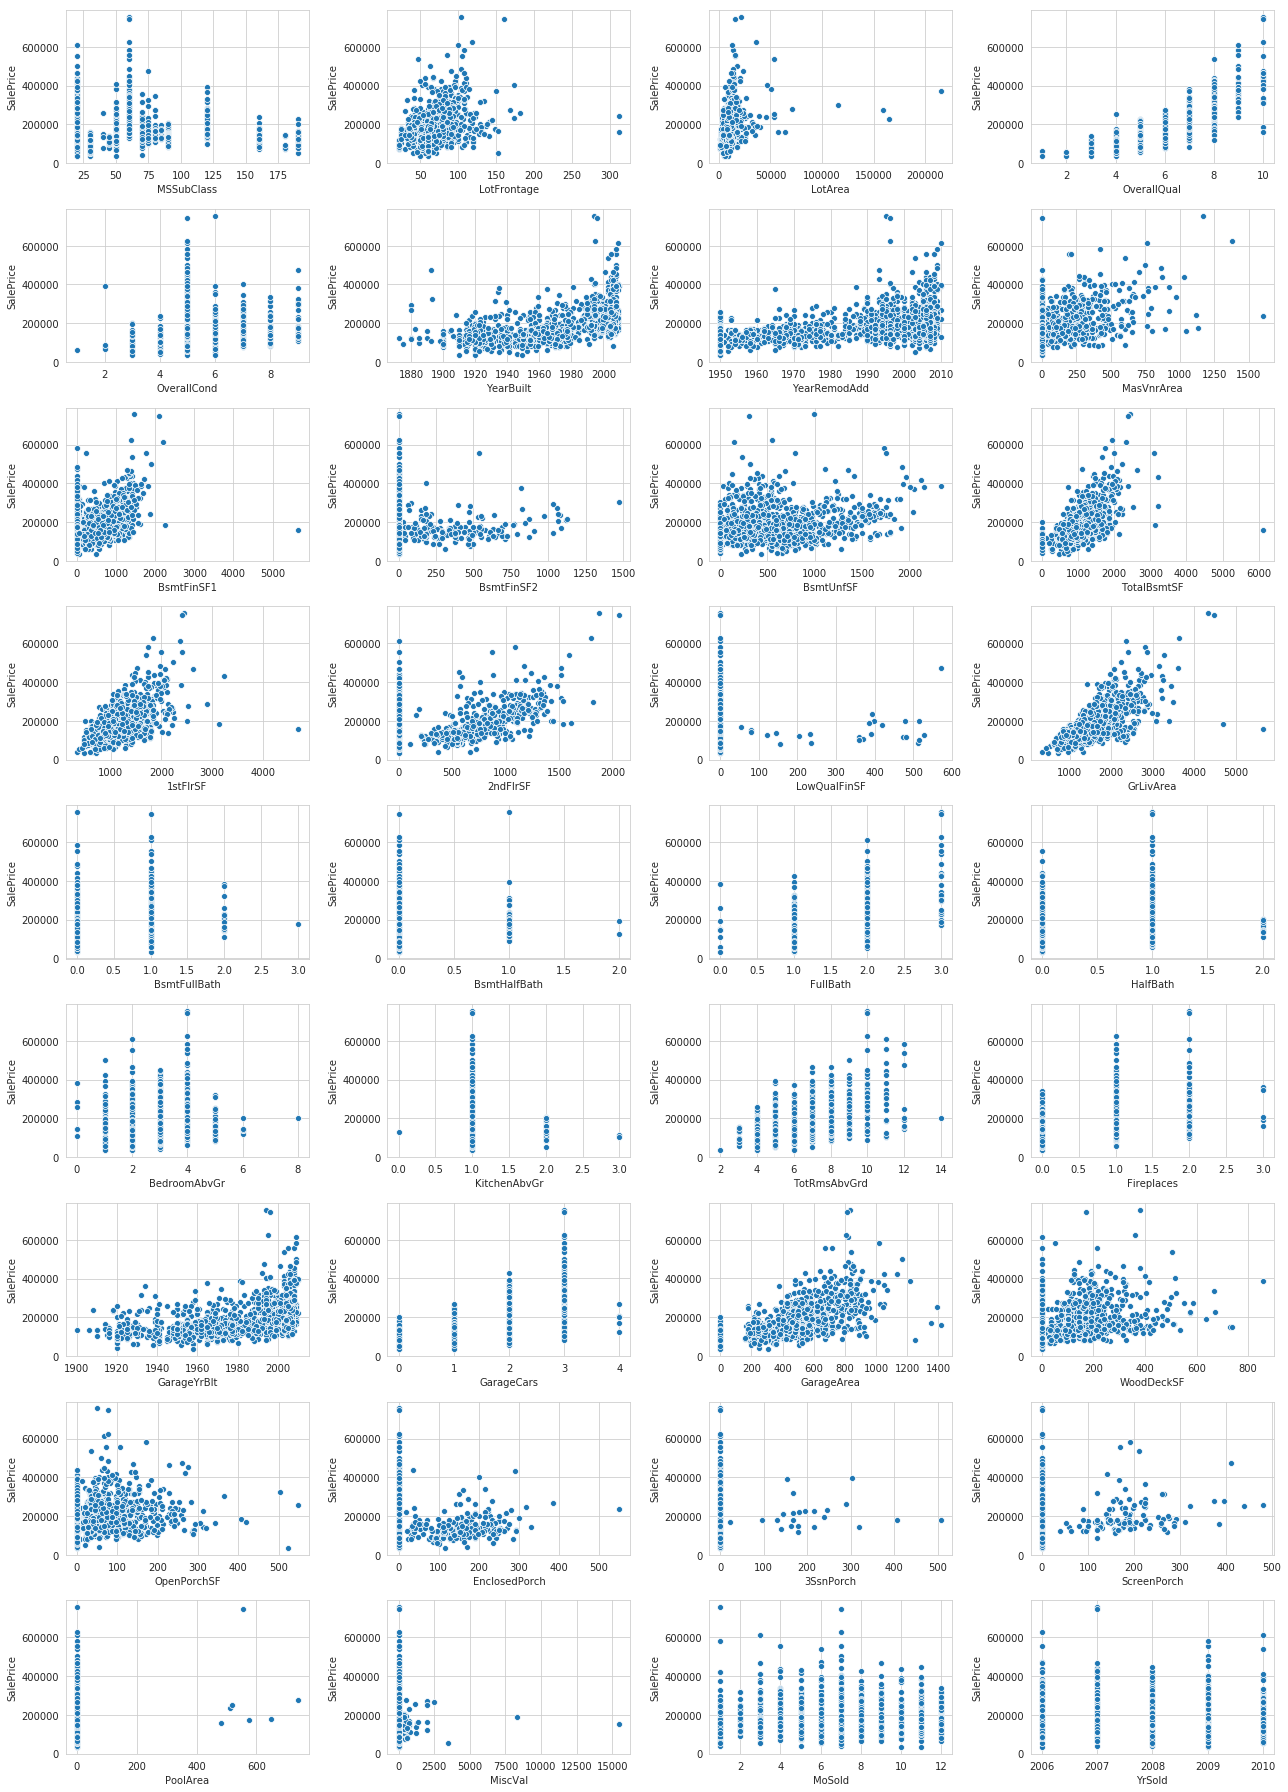

In [7]:
# Plotting scatter plots for every feature against Target
target = df_train['SalePrice']

f = plt.figure(figsize=(18,25))

for i in range(len(num_cols.columns)):
    f.add_subplot(9, 4, i+1)
    sns.scatterplot(num_cols.iloc[:,i], target)
    
plt.tight_layout()

Delete the following outliers:
- LotFrontage > 200
- LotArea > 100000
- BsmtFinSF1 > 3000
- BsmtFinSF2 > 1250
- TotalBsmtSF > 4000
- 1stFlrSF > 4000
- GrLivArea > 4000, SalePrice < 4000000
- LowQualFinSF > 550

In [8]:
# LotFrontage >200
df_train = df_train.drop(df_train[df_train['LotFrontage'] > 200].index)

# LotArea > 100000
df_train = df_train.drop(df_train[df_train['LotArea'] > 100000].index)

# BsmtFinSF1 > 3000
df_train = df_train.drop(df_train[df_train['BsmtFinSF1'] > 3000].index)

# BsmtFinSF2 > 1250
df_train = df_train.drop(df_train[df_train['BsmtFinSF2'] > 1250].index)

# TotalBsmtSF > 4000
df_train = df_train.drop(df_train[df_train['TotalBsmtSF'] > 4000].index)

# 1stFlrSF > 4000
df_train = df_train.drop(df_train[df_train['1stFlrSF'] > 4000].index)

# GrLivArea > 4000, SalePrice < 400000
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 400000)].index)

# LowQualFinSF > 550
df_train = df_train.drop(df_train[df_train['LowQualFinSF'] > 550].index)

### Check Target skewness and logarithmize if needed

Skew is: 1.8828757597682129


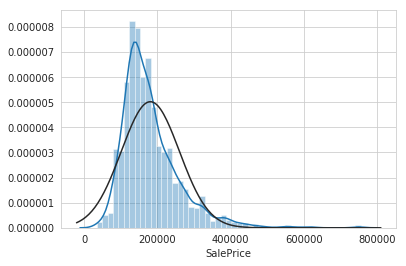

In [9]:
sns.distplot(target, fit=norm)
print('Skew is:', target.skew())

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

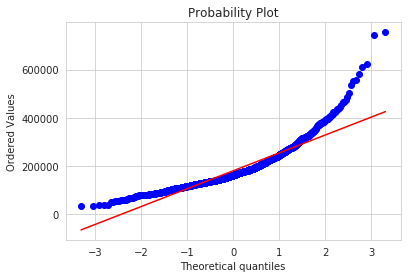

In [10]:
stats.probplot(target, plot=plt)

The target variable is right skewed.
We need to transform this variable and make it more normally distributed.

In [11]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

Skew is: 0.12039938580957864


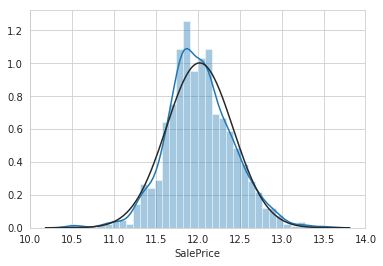

In [12]:
sns.distplot(df_train['SalePrice'], fit=norm)
print('Skew is:', df_train['SalePrice'].skew())

((array([-3.30340654, -3.04607408, -2.90296155, ...,  2.90296155,
          3.04607408,  3.30340654]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3968982961409731, 12.021092728830597, 0.9952864514494658))

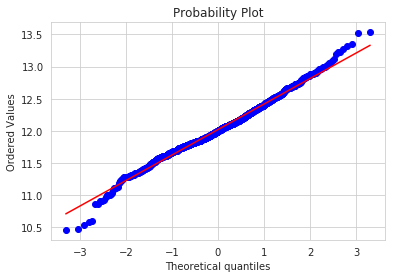

In [13]:
stats.probplot(df_train['SalePrice'], plot=plt)

Target Variable skewness has reduced from 1.88 to 0.12

### Merge train and test data to form all_data

In [14]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [15]:
all_data.shape

(2910, 79)

### Exploring missing values in the dataset

In [16]:
all_data.isnull().sum().sort_values(ascending=False).head(40)

PoolQC          2901
MiscFeature     2807
Alley           2712
Fence           2341
FireplaceQu     1420
LotFrontage      483
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
Electrical         1
Exterior2nd        1
KitchenQual        1
GarageCars         1
Exterior1st        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
Condition2         0
FullBath           0
2ndFlrSF           0
3SsnPorch          0
BedroomAbvGr       0
BldgType           0
dtype: int64

### Impute missing values appropriately till no missing values are present

In [17]:
# PoolQC - filling with None as description saya NA for houses with no pools
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

# MiscFeature - filling with None as description saya NA for houses with no miscfeatures
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

# Alley - filling with None as description saya NA for houses with no alley access
all_data['Alley'] = all_data['Alley'].fillna('None')

# Fence - filling with None as description saya NA for houses with no fence
all_data['Fence'] = all_data['Fence'].fillna('None')

# FireplaceQu - filling with None as description saya NA for houses with no fireplace
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

# LotFrontage - filling in with median LotFrontage grouped by Neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Garage_cols - fillinf in with with None as description says NA for no garage
for col in ['GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageType']:
    all_data[col] = all_data[col].fillna('None')
all_data['GarageYrBlt'].replace('None', 0)

# Garage_cols - fillinf in with 0
for col in ['GarageArea', 'GarageCars']:
    all_data[col] = all_data[col].fillna(0)
    
# Bsmt_cols (categorical) - filling in with None
for col in ['BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']:
    all_data[col] = all_data[col].fillna('None')
    
# Bsmt_cols (numerical) - filling in with 0
for col in ['BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF']:
    all_data[col] = all_data[col].fillna(0)

# MasVnrType - None, MasVnrArea - 0
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

# MSZoning - filling in with most occuring cat - RL
all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')

# Functional = filling in with most occuring cat - Typ
all_data['Functional'] = all_data['Functional'].fillna('Typ')

# Exterior2nd - filling in with most occuring cat - VinylSd
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('VinylSd')

# Exterior1st - filling in with most occuring cat - VinylSd
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('VinylSd')

# SaleType - filling in with most occuring cat - WD
all_data['SaleType'] = all_data['SaleType'].fillna('WD')

# Electrical - filling in with most occuring cat - SBrkr
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

# KitchenQual - filling in with most occuring cat - TA
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

In [18]:
# Utilities - drop the column 
all_data = all_data.drop(['Utilities'], axis=1)

In [19]:
# Checking for missing values
all_data.isnull().values.sum()

0

All missing values have been filled

### Drop highly correlated columns

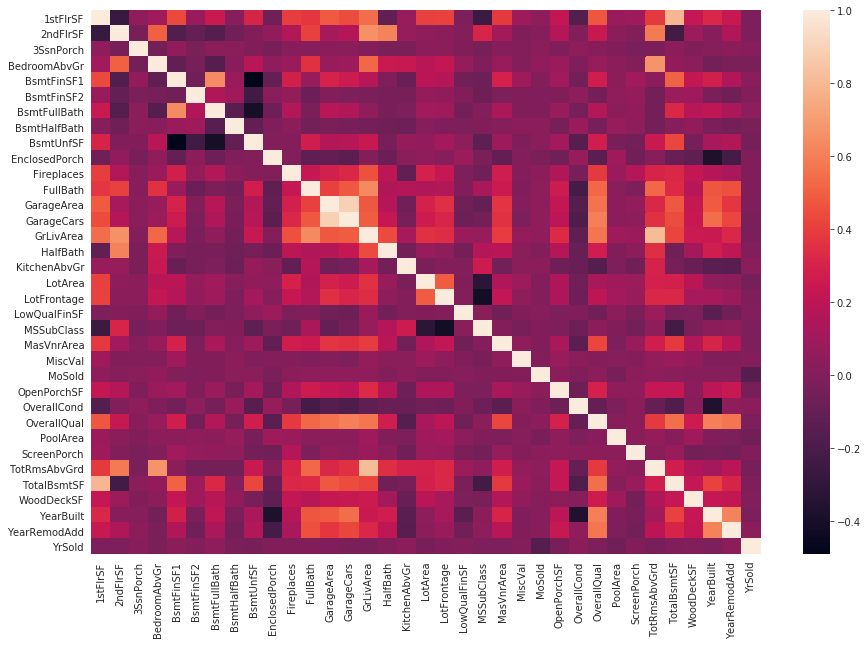

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(all_data.corr())

Strong correlation between

- GarageCars and GarageArea
- GrLiveArea and TotRmsAbvGrd
- YearBuilt and GarageYrBuilt
- TotalBsmntSF and 1stFlrSF

In [21]:
print(df_train.corr()['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.822281
GrLivArea        0.722541
GarageCars       0.681456
GarageArea       0.656382
TotalBsmtSF      0.647521
1stFlrSF         0.617581
YearBuilt        0.597665
FullBath         0.594794
YearRemodAdd     0.569189
GarageYrBlt      0.547019
TotRmsAbvGrd     0.535362
Fireplaces       0.485899
MasVnrArea       0.437479
BsmtFinSF1       0.393311
LotFrontage      0.378448
LotArea          0.360527
WoodDeckSF       0.337609
OpenPorchSF      0.323200
2ndFlrSF         0.318620
HalfBath         0.316794
BsmtFullBath     0.233757
BsmtUnfSF        0.225632
BedroomAbvGr     0.205711
ScreenPorch      0.112653
PoolArea         0.075285
3SsnPorch        0.056126
MoSold           0.056014
BsmtHalfBath    -0.007114
BsmtFinSF2      -0.010365
MiscVal         -0.021183
YrSold          -0.034568
OverallCond     -0.043219
LowQualFinSF    -0.061576
MSSubClass      -0.074519
KitchenAbvGr    -0.146941
EnclosedPorch   -0.147387
Name: SalePrice, dtype: float64


Drop columns notes:
- YearBuilt and GarageYrBlt, consider excluding GarageYrBlt as YearBuilt has a high correlation with target
- YearBuilt and YearRemodAdd
- GrLivArea has strong correlation with target as well as many other SF features
- GarageArea is highly correlated with GarageCars, so consider excluding it as GarageCars has higher correlation with target

Drop the following columns:
- GarageYrBlt
- GarageCars
- YearRemodAdd

In [22]:
all_data = all_data.drop(['GarageYrBlt', 'GarageCars', 'YearRemodAdd'], axis=1)

In [23]:
all_data.shape

(2910, 75)

### Label Encoding categorical features with high cardinality

In [24]:
# Object columns with high cardinality
high_card = [cname for cname in df_train.columns if (df_train[cname].nunique() > 10) & (df_train[cname].dtype == 'object')]

In [25]:
all_data[high_card].columns

Index(['Neighborhood', 'Exterior1st', 'Exterior2nd'], dtype='object')

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
# LabelEncoding the above columns

# Neighborhood
neigh_le = LabelEncoder()
all_data['Neighborhood'] = neigh_le.fit_transform(all_data['Neighborhood'])

# Exterior1st
ext1_le = LabelEncoder()
all_data['Exterior1st'] = ext1_le.fit_transform(all_data['Exterior1st'])

# Exterior2nd
ext2_le = LabelEncoder()
all_data['Exterior2nd'] = ext2_le.fit_transform(all_data['Exterior2nd'])

In [28]:
all_data.shape

(2910, 75)

### Exploring categorical columns with low cardinality

In [29]:
# Object columns with low cardinality
low_card = [cname for cname in all_data.columns if  (all_data[cname].nunique() <= 10) & (all_data[cname].dtype == 'object')]

In [30]:
all_data[low_card].columns

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'MiscFeature', 'PavedDrive', 'PoolQC', 'RoofMatl',
       'RoofStyle', 'SaleCondition', 'SaleType', 'Street'],
      dtype='object')

### But first transforming skewed categorical features 

In [31]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.936464
PoolArea,17.667226
LowQualFinSF,12.396873
3SsnPorch,11.358122
KitchenAbvGr,4.294580
BsmtFinSF2,4.108760
EnclosedPorch,3.996925
BsmtHalfBath,3.938882
ScreenPorch,3.927646
LotArea,3.608327


In [32]:
num_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skew_feats = all_data[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print('Skew of num_feats: ')
skewness = pd.DataFrame({'Skew' : skew_feats})
skewness.head()

Skew of num_feats: 


,Skew
MiscVal,21.936464
PoolArea,17.667226
LowQualFinSF,12.396873
3SsnPorch,11.358122
KitchenAbvGr,4.294580


In [33]:
skewness = skewness[abs(skewness) > 0.75]
print('Number of skewed features:', skewness.shape[0])

Number of skewed features: 36


In [34]:
skewed_features = skewness.index
all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [35]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCond,GarageFinish,GarageQual,GarageType,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YrSold
0,6.753438,6.751101,0.0,None,1.386294,1Fam,TA,No,6.561031,0.0,GLQ,Unf,0.693147,0.000000,Gd,5.017280,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,2.564949,2.639057,None,None,0.000000,PConc,1.098612,Typ,6.308098,TA,RFn,TA,Attchd,7.444833,0.693147,GasA,Ex,2Story,0.693147,Gd,Lvl,Gtl,9.042040,Inside,4.189655,Reg,0.0,4.110874,RL,5.283204,BrkFace,None,0.0,1.098612,1.791759,4.127134,1.791759,2.079442,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.197225,6.753438,0.000000,7.602900,7.605392
1,7.141245,0.000000,0.0,None,1.386294,1Fam,TA,Gd,6.886532,0.0,ALQ,Unf,0.000000,0.693147,Gd,5.652489,Y,Feedr,Norm,SBrkr,0.000000,TA,TA,2.197225,2.197225,None,TA,0.693147,CBlock,1.098612,Typ,6.133398,TA,RFn,TA,Attchd,7.141245,0.000000,GasA,Ex,1Story,0.693147,TA,Lvl,Gtl,9.169623,FR2,4.394449,Reg,0.0,3.044522,RL,0.000000,None,None,0.0,1.791759,3.218876,0.000000,2.197225,1.945910,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,1.945910,7.141245,5.700444,7.589336,7.604894
2,6.825460,6.765039,0.0,None,1.386294,1Fam,TA,Mn,6.188264,0.0,GLQ,Unf,0.693147,0.000000,Gd,6.075346,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,2.564949,2.639057,None,TA,0.693147,PConc,1.098612,Typ,6.411818,TA,RFn,TA,Attchd,7.488294,0.693147,GasA,Ex,2Story,0.693147,Gd,Lvl,Gtl,9.328212,Inside,4.234107,IR1,0.0,4.110874,RL,5.093750,BrkFace,None,0.0,2.302585,1.791759,3.761200,1.791759,2.079442,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,1.945910,6.825460,0.000000,7.601902,7.605392
3,6.869014,6.629363,0.0,None,1.386294,1Fam,Gd,No,5.379897,0.0,ALQ,Unf,0.693147,0.000000,TA,6.293419,Y,Norm,Norm,SBrkr,5.609472,TA,TA,2.639057,2.772589,None,Gd,0.693147,BrkTil,0.693147,Typ,6.466145,TA,Unf,TA,Detchd,7.448916,0.000000,GasA,Gd,2Story,0.693147,Gd,Lvl,Gtl,9.164401,Corner,4.110874,IR1,0.0,4.262680,RL,0.000000,None,None,0.0,1.098612,1.945910,3.583519,1.791759,2.079442,Y,0.0,None,CompShg,Gable,Abnorml,WD,0.0,Pave,2.079442,6.629363,0.000000,7.557995,7.604396
4,7.044033,6.960348,0.0,None,1.609438,1Fam,TA,Av,6.486161,0.0,GLQ,Unf,0.693147,0.000000,Gd,6.196444,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,2.564949,2.639057,None,TA,0.693147,PConc,1.098612,Typ,6.729824,TA,RFn,TA,Attchd,7.695758,0.693147,GasA,Ex,2Story,0.693147,Gd,Lvl,Gtl,9.565284,FR2,4.442651,IR1,0.0,4.110874,RL,5.860786,BrkFace,None,0.0,2.564949,2.772589,4.442651,1.791759,2.197225,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.302585,7.044033,5.262690,7.601402,7.605392


### One Hot Encoding the remaining categorical features with low cardinality

In [36]:
all_data = pd.get_dummies(data=all_data, columns=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'], drop_first=True)

In [37]:
all_data.shape

(2910, 204)

### Split the dataset back to train and test

In [38]:
X = all_data[:ntrain]
X_test = all_data[ntrain:]
y = df_train['SalePrice']

### Make sure that all the missing values have been imputed and categorical features have been transformed

In [39]:
print('Train Null Values:', X.isnull().values.sum())
print('Test Null Values:', X_test.isnull().values.sum())
print('Train categorical features:', X.select_dtypes(include='object').values.sum())
print('Test categorical features:', X_test.select_dtypes(include='object').values.sum())

Train Null Values: 0
Test Null Values: 0
Train categorical features: 0.0
Test categorical features: 0.0


## Modeling

Models we'll be using:
- Random Forest
- Gradient Boosting
- Linear regression
- Lasso
- Ridge
- KNNRegression

In [40]:
# Imports
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

### Breaking the training data from the validation data

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=100)

### Create a function to inverse transform SalePrive after prediction call

In [42]:
# Target is log(SalePrice). After prediction call, need to inverse transform to obtain SalePrice

def inv_y(trans_y):
    return np.exp(trans_y)

### Build series to collate mean absolute errors for each algorithm

In [43]:
mae_comp = pd.Series()
mae_comp.index.name = 'Algorithm'

### Implementing the selected models

In [44]:
# Random Forest 

rf_model = RandomForestRegressor(random_state=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_mae = mean_absolute_error(inv_y(rf_preds), inv_y(y_val))
mae_comp['RandomForest'] = rf_mae

In [45]:
# Linear Regression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_val)
lin_mae = mean_absolute_error(inv_y(lin_preds), inv_y(y_val))
mae_comp['LinearRegression'] = lin_mae

In [46]:
# Lasso

las_model = Lasso(alpha=0.00005, random_state=100)
las_model.fit(X_train, y_train)
las_preds = las_model.predict(X_val)
las_mae = mean_absolute_error(inv_y(las_preds), inv_y(y_val))
mae_comp['Lasso'] = las_mae

In [47]:
# KNNRegression

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_val)
knn_mae = mean_absolute_error(inv_y(knn_preds), inv_y(y_val))
mae_comp['KNN'] = knn_mae

In [48]:
# Ridge

ridge_model = Ridge(alpha=0.002, random_state=100)
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_val)
ridge_mae = mean_absolute_error(inv_y(ridge_preds), inv_y(y_val))
mae_comp['Ridge'] = ridge_mae

In [49]:
# ElasticNet

elas_model = ElasticNet(alpha=0.02, random_state=100, l1_ratio=0.7)
elas_model.fit(X_train, y_train)
elas_preds = elas_model.predict(X_val)
elas_mae = mean_absolute_error(inv_y(elas_preds), inv_y(y_val))
mae_comp['ElasticNet'] = elas_mae

In [50]:
# Gradient Boosting Regression

gbr_model = GradientBoostingRegressor(learning_rate=0.01, 
                                      subsample = 0.8, 
                                      n_estimators=1000, 
                                      max_depth=4
                                     )
gbr_model.fit(X_train, y_train)
gbr_preds = gbr_model.predict(X_val)
gbr_mae = mean_absolute_error(inv_y(gbr_preds), inv_y(y_val))
mae_comp['GradientBoosting'] = gbr_mae

### Identify the model with the lowest mean absolute error

In [51]:
mae_comp

Algorithm
RandomForest        18258.362036
LinearRegression    15454.946130
Lasso               15530.648205
KNN                 31652.254478
Ridge               15494.997252
ElasticNet          24084.589962
GradientBoosting    16110.217631
dtype: float64

In [52]:
mae_comp.min()

15454.946130456214

### Cross Validate models

In [53]:
def score(model):
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return np.sqrt(-score)

In [54]:
scores= {}

In [55]:
scores.update({'RandomForest' : score(rf_model)})
scores.update({'LinearRegression' : score(lin_model)})
scores.update({'Lasso' : score(las_model)})
scores.update({'KNN' : score(knn_model)})
scores.update({'Ridge' : score(ridge_model)})
scores.update({'ElasticNet' : score(elas_model)})
scores.update({'GradientBoosting' : score(gbr_model)})

In [56]:
scores

{'RandomForest': 0.1423807164821275,
 'LinearRegression': 0.14101215571340978,
 'Lasso': 0.12245380458776219,
 'KNN': 0.24020205498246,
 'Ridge': 0.13135881240579406,
 'ElasticNet': 0.17167570091113488,
 'GradientBoosting': 0.1186899960882104}

In [57]:
min(scores.values())

0.1186899960882104

### Fitting the winning model as the final model

After doing a few test submissions, the GradientBoosting model is giving me a much better score than the other models. Even though Ridge had the lowest MAE on my split data, it's performance on the test data is horrible. This maybe due to data leakage issues or not tuning the model properly. Not sure, but i'll be selecting GrandientBoosting as the winning model.

In [58]:
final_model = GradientBoostingRegressor(learning_rate=0.01, 
                                      subsample = 0.8, 
                                      n_estimators=1000, 
                                      max_depth=4
                                     )
final_model.fit(X, y)
final_preds = final_model.predict(X_test)

### Create submissions file

In [59]:
output = pd.DataFrame({'Id': test_id,
                      'SalePrice' : inv_y(final_preds)})

In [60]:
output.to_csv('Submission.csv', index=False)